In [1]:
import os
import lsst.afw.geom as afwGeom
import lsst.afw.table as afwTable
import pickle

import numpy as np

import lsst.daf.persistence as dafPersist
import re
import astropy.coordinates as coord
import astropy.units as u

import matplotlib.pyplot as plt
from astropy.table import Table

/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2016-04-04/lsstsw/miniconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [43]:
def match_with_data(input_data, control_data):
    
    matches = []
    for data in input_data:

        match = False
        c = coord.SkyCoord(data[-1], unit=(u.hourangle, u.deg))


        for i, lc in enumerate(control_data):
            #print lc[0]['ra']
            #print lc[0]['dec']
            if source_distance(lc[0], {'ra':c.ra.radian, 'dec':c.dec.radian}) < 2:
                match = True

                matches.append((data[0], i))
                break

            #print 'no match'
    print 'found ' + str(float(len(matches))/float(len(elems))) 
    
def threshold_light_curves(light_curves, threshold):
    t_light_curves = [lc for lc in light_curves if len(lc) >= threshold]
    return t_light_curves

In [2]:
pkl_file = open('mjd_dict.pickle', 'rb')
mjds = pickle.load(pkl_file)


In [3]:

DATADIR="/renoir_data_02/jpreyes/lsst_data/CFHTLS_master/"
butler = dafPersist.Butler(DATADIR+"/output") 

We have to get each class_diaSrc catalog and use it for the multimatch function

In [39]:
season_catalogs = []
data_refs = []
for c_id in cat_ids:
    if  butler.datasetExists("deepDiff_class_diaSrc", {"ccd":c_id[0],"filter":c_id[1], "visit":c_id[2]}):
        data_refs.append({"ccd":c_id[0],"filter":c_id[1], "visit":c_id[2]})
        season_catalogs.append(butler.get("deepDiff_class_diaSrc", {"ccd":c_id[0],"filter":c_id[1], "visit":c_id[2]}))

In [ ]:

multi_matches = None

for s_catalog, data_ref in zip(season_catalogs, data_refs):
           
        if multi_matches is None and len(s_catalog)>0:
            multi_matches = afwTable.MultiMatch(s_catalog[0].schema, {'visit':int, 'ccd':int}, radius=afwGeom.Angle(1./3600., afwGeom.degrees))
        if multi_matches is not None:
            multi_matches.add(s_catalog, {'visit':data_ref["visit"], 'ccd':data_ref["ccd"] })

results = multi_matches.finish(removeAmbiguous=False)  
print len(results)

In [ ]:
light_curves = []
i = 0
current = -1
while i < len(results):
    result = results[i]
    if current == -1 or current != result['object']:
        lc = [(result['visit'],result)]
        light_curves.append(lc)
        current = result['object']
    else:
        light_curves[-1].append((result['visit'],result))
    i+=1
    

In [44]:
t_light_curves = threshold_light_curves(light_curves, 10)
print len(t_light_curves)

10480


In [41]:
print len(results)

4628645


In [47]:
def source_distance(src1, src2):
    ra, dec = src1['ra'], src1['dec']
    ra2, dec2 = src2['ra'], src2['dec']
            
    return np.sqrt((float(ra)-float(ra2))**2+(float(dec)-float(dec2))**2)/3.14159*180*3600

def threshold_light_curves(light_curves, threshold):
    t_light_curves = [lc for lc in light_curves if len(lc) >= threshold]
    return t_light_curves

def build_light_curve_from_snls_file(data):

 

    lightcurve = {}
    lightcurve['bandpass'] = []
    lightcurve['mjd'] = []
    #lightcurve['ra'] = []
    #lightcurve['dec'] = []
    lightcurve['flux'] = []
    lightcurve['flux_error'] = []
    lightcurve['zp'] = []
    lightcurve['zpsys'] = []


    for bandpass, mjd, flux, error in data:

        #print 'yep',visit
        lightcurve['bandpass'].append(str('sdss' + bandpass))
        lightcurve['mjd'].append(float(mjd))
        #lightcurve['ra'].append(c.ra.radian)
        #lightcurve['dec'].append(c.dec.radian)
        lightcurve['flux'].append(float(flux))
        lightcurve['flux_error'].append(float(error))
        #lightcurve['flux'].append(src['base_CircularApertureFlux_12_0_flux'])
        #lightcurve['flux_error'].append(src['base_CircularApertureFlux_12_0_fluxSigma'])
        lightcurve['zp'].append(25.0)
        lightcurve['zpsys'].append('ab')

    lc = Table(data=lightcurve)
    return lc

def build_lightcurve(source_list):
    """
    Assemble a light curve data table from available files.
    """



    lightcurve = {}
    lightcurve['classification'] = []
    lightcurve['bandpass'] = []
    lightcurve['mjd'] = []
    lightcurve['ra'] = []
    lightcurve['dec'] = []
    lightcurve['flux'] = []
    lightcurve['flux_error'] = []
    lightcurve['zp'] = []
    lightcurve['zpsys'] = []


    for visit, src in source_list:

        #print 'yep',visit
        #bandpass = 'r' if src["filter"]==1 else 'i'
        bandpass = 'r'
        lightcurve['classification'].append(src['classification_dipole'])
        lightcurve['bandpass'].append(str('sdss' + bandpass))
        
        lightcurve['mjd'].append(mjds[str(visit)])
        lightcurve['ra'].append(src['coord_ra'])
        lightcurve['dec'].append(src['coord_dec'])
        lightcurve['flux'].append(src['base_CircularApertureFlux_4_5_flux'])
        lightcurve['flux_error'].append(src['base_CircularApertureFlux_4_5_fluxSigma'])
        #lightcurve['flux'].append(src['base_CircularApertureFlux_12_0_flux'])
        #lightcurve['flux_error'].append(src['base_CircularApertureFlux_12_0_fluxSigma'])
        lightcurve['zp'].append(25.0)
        lightcurve['zpsys'].append('ab')
    lightcurve = Table(data=lightcurve)
    return lightcurve

def mean_lc_flux(lc2):

    mjds = []
    m_fluxes = []
    m_error = []
    s_error = []
    i = 0
    while i < len(lc2['mjd']):
        mjd = lc2['mjd'][i]
        j = i+1
        mjds.append(int(mjd))
        m_fluxes.append(lc2['flux'][i]*lc2['flux_error'][i])
        m_error.append(lc2['flux_error'][i])
        s_error.append(lc2['flux_error'][i]**2)
        total = 1.
       
        while j<len(lc2['mjd']) and int(lc2['mjd'][j]) == int(mjd):

            m_fluxes[-1]+= lc2['flux'][j]*lc2['flux_error'][j]
            

                
            m_error[-1] += lc2['flux_error'][j]
            s_error[-1] += (lc2['flux_error'][j]**2)
            #mjds[-1] += int(lc2['mjd'][j])
            total+=1
            j+=1
            
       
        m_fluxes[-1] = np.divide(m_fluxes[-1], m_error[-1] )
        m_error[-1] = np.divide(np.sqrt(s_error[-1]), total)
        i = j

    return mjds, m_fluxes, m_error


In [48]:
lcs = []
for t_light_curve in t_light_curves:
    lcs.append(build_lightcurve(t_light_curve))

blue
red


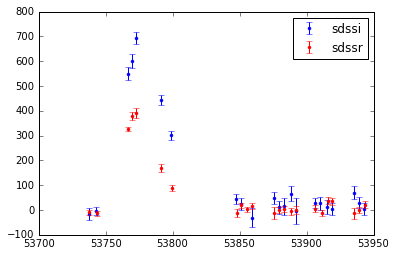

blue
red


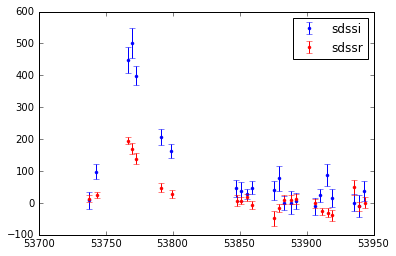

blue
red


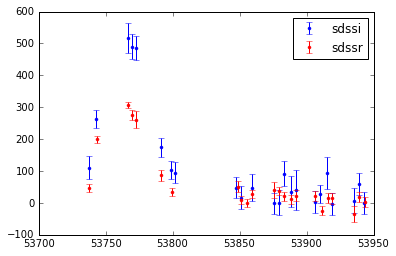

blue
red


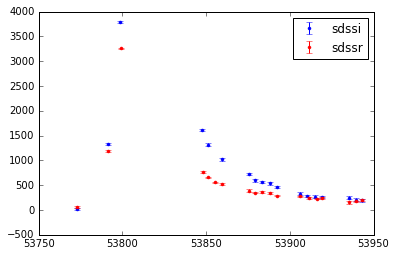

blue
red


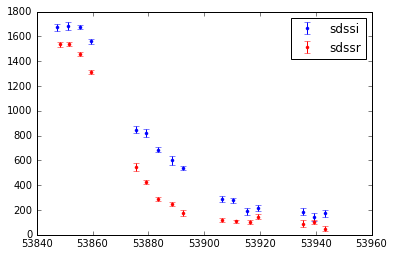

blue
red


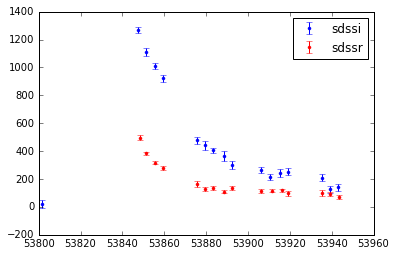

blue
red


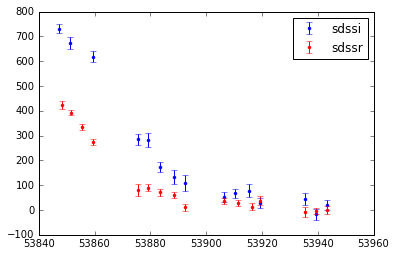

blue
red


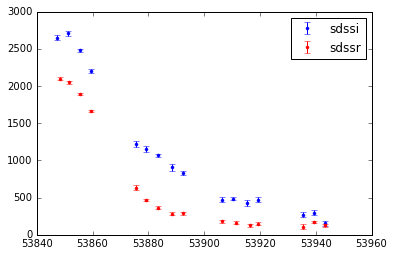

blue
red


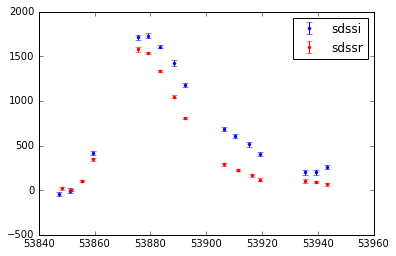

blue
red


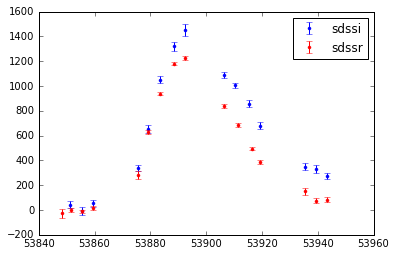

blue
red


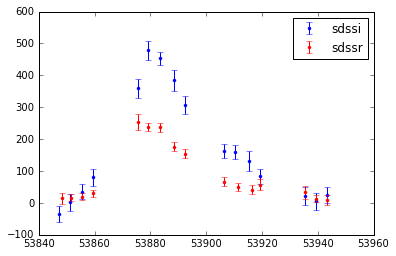

blue
red


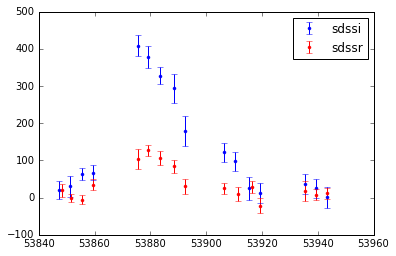

blue
red


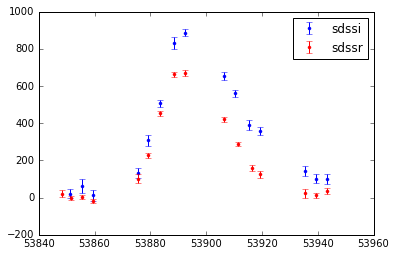

blue
red


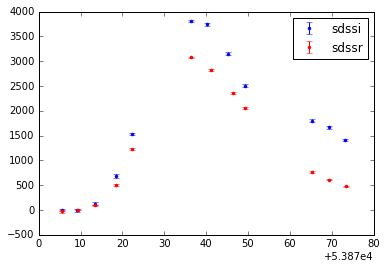

blue
red


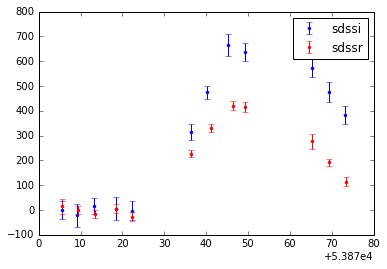

blue
red


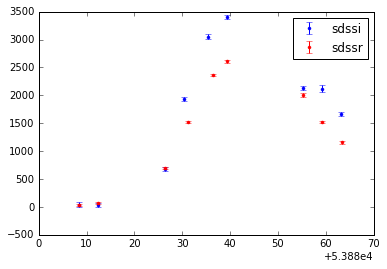

blue
red


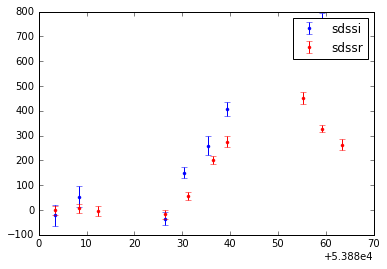

In [50]:


f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table9.dat.txt','r')
data_elems = f.read()
#m = re.findall('^06D3.*?\\|(.*?)\\|', data, re.MULTILINE)
elems = re.findall('^(06D3.*?)\\|(.*?)\\|', data_elems, re.MULTILINE)

f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table10.dat.txt','r')
data = f.read()

colors = ["blue", "red", "yellow", "green", "black"]

%matplotlib inline
snls_array = []
for sn in elems:
    
    c = coord.SkyCoord(sn[-1], unit=(u.hourangle, u.deg))
    
    m = re.findall('^'+str(sn[0])+'\\|(r|i)\\|(.*?)\\|(.*?)\\|(.*?)$', data, re.MULTILINE)

    snls_lc = build_light_curve_from_snls_file(m)
    
    g_lc = snls_lc.group_by("bandpass")
    filters = g_lc.groups
    for i  in range(0,len(filters)):
        
        f_lc = g_lc[filters.indices[i]:filters.indices[i+1]]
        print colors[i%len(colors)]
        plt.errorbar(f_lc['mjd'], f_lc['flux'], yerr=f_lc['flux_error'], fmt='.', color=colors[i%len(colors)], label=f_lc[0]["bandpass"])
    
    snls_array.append(snls_lc)
    plt.legend(numpoints=1)
    plt.show()

In [53]:

matches = []
for sn in elems:
    
    match = False
    c = coord.SkyCoord(sn[-1], unit=(u.hourangle, u.deg))
    
    
    for i, lc in enumerate(lcs):
        #print lc[0]['ra']
        #print lc[0]['dec']
        if source_distance(lc[0], {'ra':c.ra.radian, 'dec':c.dec.radian}) < 2:
            match = True
 
            matches.append((sn[0], i))
            break
    
        #print 'no match'
print 'found ' + str(float(len(matches))/float(len(elems))) 

found 0.352941176471


In [52]:
print len(lcs)

10480
